# Calculate Past, Current, and Future Mill Risk Scores using Tree Cover Loss Data and Aggregate Brand Risk
### All risk calculations are replicated in the batch layer which produces the data that serves the Tracker application.
### Risk calculation method is modeled after the PALM risk tool developed by the World Resources Institute (detailed [here](https://files.wri.org/s3fs-public/Palm_Risk_Assessment_Methodology_Prioritizing_Areas_Landscapes_And_Mills.pdf)).

In [1]:
# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import os

In [2]:
# Parameters
DATA_DIR = "../data"
MILL_LOSS_FNAME = 'uml_loss.csv'
BRAND_MILL_MATCHES_FNAME = 'brand_mills.csv'
BRAND_INFO_FNAME = 'brand_info.csv'

In [3]:
# Bring in Mills Tree Cover Loss data.
loss_file_path = os.path.join(DATA_DIR, MILL_LOSS_FNAME)
df = pd.read_csv (loss_file_path)
df['umlid'] = df['umlid'].str.lower()
df.head()

,umlid,treeloss_sum,land_area,forest_area,treeloss_2001,treeloss_2002,treeloss_2003,treeloss_2004,treeloss_2005,treeloss_2006,...,treeloss_2013,treeloss_2014,treeloss_2015,treeloss_2016,treeloss_2017,treeloss_2018,treeloss_2019,treeloss_sum_proportion_of_land,treeloss_sum_proportion_of_forest,remaining_proportion_of_forest
0,po1000000021,1906.499294,7161.378706,5110.225765,247.503529,72.550235,0.810000,27.959294,56.750824,117.159176,...,6.826235,80.903294,25.444235,251.816118,101.639294,358.871294,358.554706,0.266220,0.373075,0.626925
1,po1000000054,15316.790118,26077.698706,21678.912000,1488.427765,339.160235,53.039647,2621.975647,413.567294,33.870706,...,993.768000,1140.495882,177.437294,1425.052941,256.883647,463.839529,1809.525176,0.587352,0.706529,0.293471
2,po1000000058,4651.115294,13248.475765,9117.221294,44.759294,56.023765,41.248588,174.501176,101.384471,193.381059,...,81.580941,745.530706,534.654353,336.262235,259.358471,504.688941,126.654706,0.351068,0.510146,0.489854
3,po1000000092,9652.010118,26006.595882,18086.659765,576.822706,768.397412,113.075647,542.520353,252.378706,346.090588,...,551.062941,719.165647,403.048588,362.144824,796.576235,770.922706,652.863882,0.371137,0.533654,0.466346
4,po1000000095,2360.988706,5650.993765,3973.180588,525.207529,13.588235,70.791529,280.605176,61.301294,64.769647,...,112.750588,41.353765,148.994118,342.013412,67.116353,58.680000,121.770000,0.417801,0.594231,0.405769


#### Risk score method
1. Choose a metric (ex: cumulative past tree loss)
2. Convert the metric to a z-score (relative to mean and standard deviation)
3. Convert the z-score to a 1-5 risk score.
- risk score 1: z < -1
- risk score 2: -1 <= z < -0.5
- risk score 3: -0.5 <= z <= 0.5
- risk score 4: 0.5 < z <= 1
- risk score 5: z > 1

In [4]:
def get_z(df, col):
    '''
    This function calculates the z-score from a specified column of a dataset.
    '''
    mu = df[col].mean()
    sd = df[col].std()
    return (df[col] - mu)/sd

In [5]:
def get_risk_from_z(df, z_col):
    rv = 5*(df[z_col] > 1) + \
          4*(df[z_col].between(0.5, 1)) + \
          3*(df[z_col].between(-0.5, 0.5)) + \
          2*(df[z_col].between(-1, -0.5)) + \
          1*(df[z_col] < -1)

    return rv

### Past Risk Calculation
#### The metric for past risk is cumulative treeloss from 2001-2019 as a proportion of forest.

Text(0, 0.5, 'mill count')

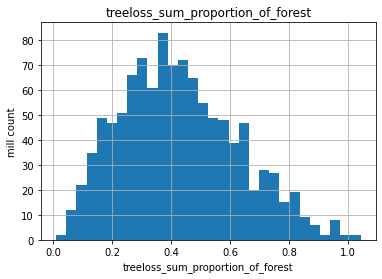

In [6]:
# Look at the distribution of the past risk metric.
df.hist('treeloss_sum_proportion_of_forest', bins=30)
plt.xlabel('treeloss_sum_proportion_of_forest')
plt.ylabel('mill count')

In [7]:
# Create a new column that is the z-score for the sqrt tree loss proportion.
df['past_risk_z'] = get_z(df, 'treeloss_sum_proportion_of_forest')

In [8]:
# Create a new column that is the risk (1-5) associated with z-score
# of past tree loss
df['risk_score_past'] = get_risk_from_z(df, 'past_risk_z')

### Current Risk Calculation
#### The metric for current risk is mean treeloss from 2018-2019 as a proportion of forest.

In [9]:
# Add a column for mean treeloss 2018/2019.
cols = ['treeloss_2018', 'treeloss_2019']
df['mean_treeloss_1819'] = df.loc[:, cols].mean(axis=1)

# Add a column for mean_treeloss_1819 as a proportion of forest.
df['mean_treeloss_1819_proportion_of_forest'] = df['mean_treeloss_1819']/df['forest_area']

Text(0, 0.5, 'mill count')

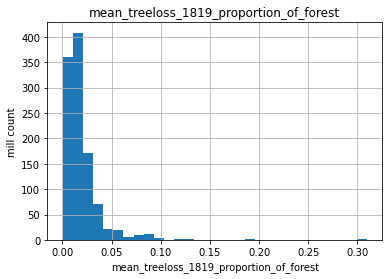

In [10]:
# Plot a histogram of the proposed current risk metric.
df.hist('mean_treeloss_1819_proportion_of_forest', bins=30)
plt.xlabel('mean_treeloss_1819_proportion_of_forest')
plt.ylabel('mill count')

Try a transformation to make this distribution look more symmetric. Take the square root.

In [11]:
df['adj_mean_treeloss_1819_proportion_of_forest'] = np.sqrt(df['mean_treeloss_1819_proportion_of_forest'])

Text(0, 0.5, 'mill count')

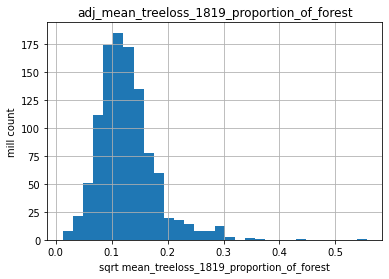

In [12]:
# Plot a histogram of the adjusted current risk metric.
df.hist('adj_mean_treeloss_1819_proportion_of_forest', bins=30)
plt.xlabel('sqrt mean_treeloss_1819_proportion_of_forest')
plt.ylabel('mill count')

In [13]:
# Add columns for z score and risk.
df['current_risk_z'] = get_z(df, 'adj_mean_treeloss_1819_proportion_of_forest')
df['risk_score_current'] = get_risk_from_z(df, 'current_risk_z')

### Future Risk Calculation
#### The z-score for future risk is 50% current risk z and 50% remaining proportion of forest.

In [14]:
# Get the z-score for remaining proportion of forest.
df['remaining_forest_z'] = get_z(df, 'remaining_proportion_of_forest')

In [15]:
df['future_risk_z'] = 0.5*df['current_risk_z'] + 0.5*df['remaining_forest_z']
df['risk_score_future'] = get_risk_from_z(df, 'future_risk_z')

Text(0, 0.5, 'mill count')

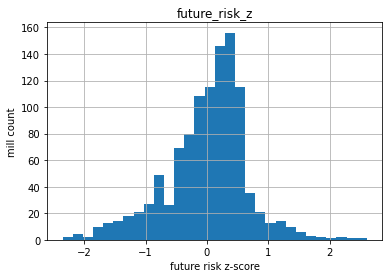

In [16]:
# Plot a histogram for the future risk score z-score.
df.hist('future_risk_z', bins=30)
plt.xlabel('future risk z-score')
plt.ylabel('mill count')

This shape means more of the mills will have a future risk of 3.

## Brand Risk Analysis

In [17]:
# Bring in brand-mill matches.
match_file_path = os.path.join(DATA_DIR, BRAND_MILL_MATCHES_FNAME)
match_df = pd.read_csv(match_file_path)

# Bring in brand info.
brand_info_file_path = os.path.join(DATA_DIR, BRAND_INFO_FNAME)
brand_info_df = pd.read_csv(brand_info_file_path)
brand_info_df.rename(columns={'id':'brandid', 'name':'brand'}, inplace=True)

In [18]:
# Merge brand info and matches data frames on brandid.
df1 = match_df.merge(brand_info_df[['brandid', 'brand']], on='brandid', how='left')

In [19]:
# Merge with mill loss/risk data.
brands_df = df1.merge(df, on='umlid', how='left')
brands_df.dropna(subset=['treeloss_sum'], inplace=True)
brands_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8169 entries, 0 to 8426
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   brandid                                      8169 non-null   int64  
 1   umlid                                        8169 non-null   object 
 2   brand                                        8169 non-null   object 
 3   treeloss_sum                                 8169 non-null   float64
 4   land_area                                    8169 non-null   float64
 5   forest_area                                  8169 non-null   float64
 6   treeloss_2001                                8169 non-null   float64
 7   treeloss_2002                                8169 non-null   float64
 8   treeloss_2003                                8169 non-null   float64
 9   treeloss_2004                                8169 non-null   float64
 10  

In [20]:
# Get mean risk scores for each brand.
agg_df = brands_df.groupby('brandid').agg({'brand':'first',
                                           'umlid':'count',
                                           'risk_score_past':'mean',
                                           'risk_score_current':'mean',
                                           'risk_score_future':'mean'})
agg_df.rename(columns={'umlid':'mill_count'}, inplace=True)
agg_df.head(13)

,brand,mill_count,risk_score_past,risk_score_current,risk_score_future
brandid,,,,,
1,Ferrero,31,3.225806,3.064516,2.903226
2,Kellogg Company,930,2.973118,2.935484,2.963441
3,PepsiCo,932,2.977468,2.927039,2.957082
4,Royal FrieslandCampina N.V.,367,3.002725,2.912807,2.937330
5,Johnson & Johnson,751,2.988016,2.925433,2.956059
6,"General Mills, Inc",934,2.986081,2.935760,2.958244
7,The Hershey Company,904,2.953540,2.923673,2.970133
8,L'Oreal,807,2.955390,2.921933,2.966543
9,The Procter & Gamble Company,461,2.943601,2.908894,2.960954


<AxesSubplot:xlabel='brand'>

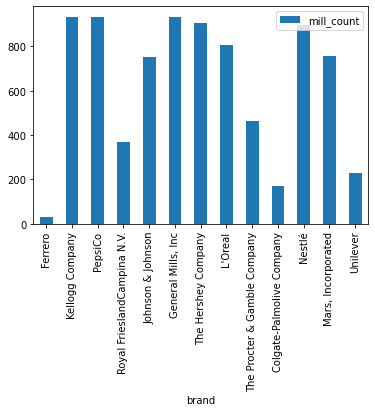

In [21]:
# Plot mill count.
agg_df.plot('brand', 'mill_count', kind='bar')

<AxesSubplot:xlabel='brand'>

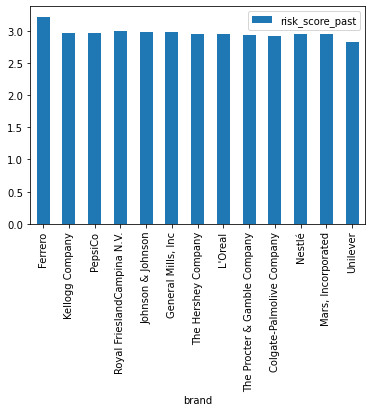

In [22]:
# Plot brand past risk.
agg_df.plot('brand', 'risk_score_past', kind='bar')

<AxesSubplot:xlabel='brand'>

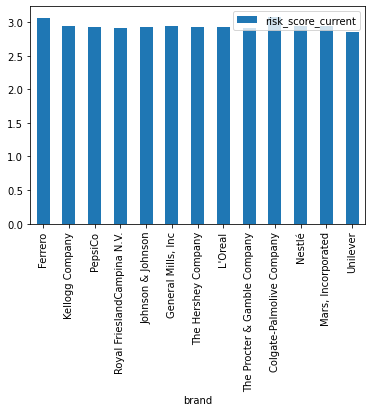

In [23]:
# Plot brand current risk.
agg_df.plot('brand', 'risk_score_current', kind='bar')

<AxesSubplot:xlabel='brand'>

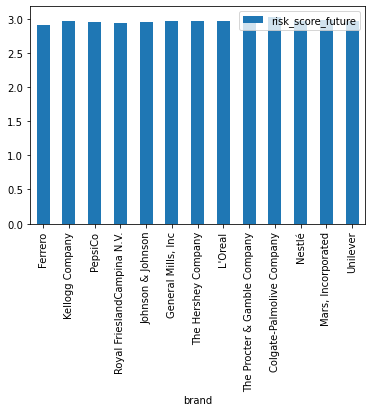

In [24]:
# Plot brand future risk.
agg_df.plot('brand', 'risk_score_future', kind='bar')

The mean score for every brand is very close to 3 - which is the average score for all mills.  This makes sense for brands like Kellogg who source from most mills, but it's also true for Ferrero which only has 31 mills, so we can infer that brands are not choosing mills based on deforestation.